# **Project Overview**

This RFM Analysis project segments customers based on Recency, Frequency, and Monetary value using KMeans clustering. By analyzing purchasing behavior, we identify key customer segments, such as high-value and frequent shoppers. Data processing and clustering are performed in Python, while Power BI is used for intuitive visualizations, allowing stakeholders to gain actionable insights. The project supports targeted marketing and improved customer retention.

# **Data Preprocessing**

### **1. Load dataset**

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [145]:
df = pd.read_excel('data.xlsx')

### **2. Handling missing values**

In [146]:
# check dataset
df.count()

InvoiceNo      541909
StockCode      541909
Description    540455
Quantity       541909
InvoiceDate    541909
UnitPrice      541909
CustomerID     406829
Country        541909
dtype: int64

**Note**: After examining the dataset, I noticed a large amount of missing data. I will proceed to delete the columns with missing values. I chose this approach because most of the missing data is in the CustomerID column; using a data-filling method could lead to skewed results.

In [147]:
# drop missing values
df.dropna(inplace=True)

In [148]:
# check the dataset again
df.count()

InvoiceNo      406829
StockCode      406829
Description    406829
Quantity       406829
InvoiceDate    406829
UnitPrice      406829
CustomerID     406829
Country        406829
dtype: int64

### **3. Handling Error Values**

In [149]:
# Check Quantity of each product
for i in df["Quantity"]:
    if i <= 0:
        print("Invalid Quantity")
        break

for j in df["UnitPrice"]:
    if i <= 0:
        print("Invalid UnitPrice")
        break

Invalid Quantity
Invalid UnitPrice


**Note**: The data in the Quantity and UnitPrice columns contains many negative values, so I will proceed to correct them.

In [150]:
# Quantity should be greater than 0
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [151]:
# Check the dataset again
df.count()

InvoiceNo      397884
StockCode      397884
Description    397884
Quantity       397884
InvoiceDate    397884
UnitPrice      397884
CustomerID     397884
Country        397884
dtype: int64

### **4. Change Datatypes**

In [152]:
# change CustomerID to int
df['CustomerID'] = df['CustomerID'].astype(int)

In [153]:
# change InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%Y-%m-%d %H:%M:%S')

In [154]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int32
Country                object
dtype: object

In [155]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


### **5. Calculate RFM**

In [156]:
# Calculate RFM
import datetime
current_date = max(df['InvoiceDate']) + datetime.timedelta(days=1)

df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
df_customer = df.groupby('CustomerID').agg(
    {
     "InvoiceDate": lambda x: (current_date - x.max()).days,
     "InvoiceNo": "count",
     "TotalPrice": "sum"
    }
)

In [157]:
# Rename the columns
df_customer.rename(columns={"InvoiceDate": "Recency", "InvoiceNo": "Frequency", "TotalPrice": "Monetary"}, inplace=True)

In [158]:
# check the dataset
df_customer

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,2,182,4310.00
12348,75,31,1797.24
12349,19,73,1757.55
12350,310,17,334.40
...,...,...,...
18280,278,10,180.60
18281,181,7,80.82
18282,8,12,178.05


### **6. Check Distribution of RFM columns**

<Axes: xlabel='Monetary', ylabel='Count'>

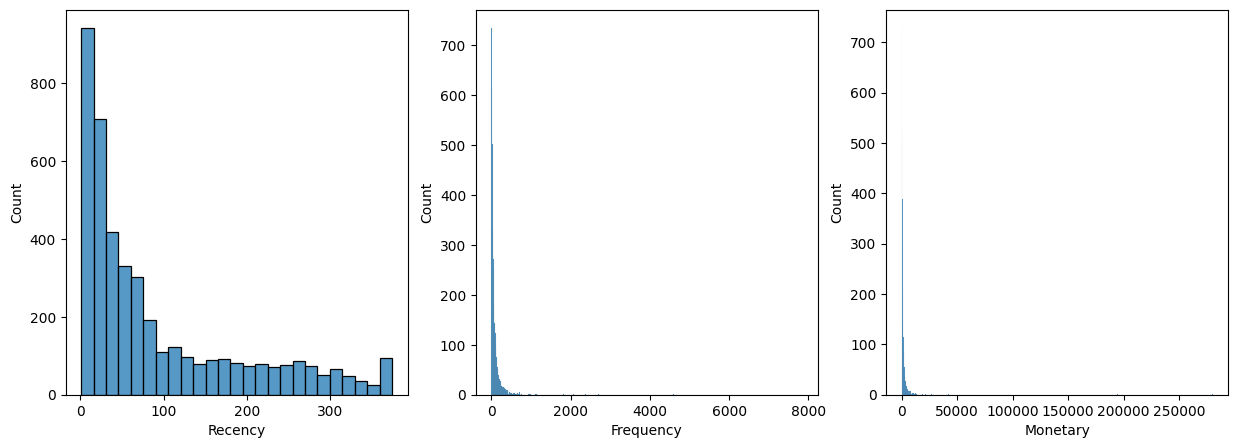

In [159]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(df_customer["Recency"], ax=ax[0])
sns.histplot(df_customer["Frequency"], ax=ax[1])
sns.histplot(df_customer["Monetary"], ax=ax[2])

**Note**: We can see that the data distribution of the three features does not follow normal distribution and has high skewness. I will consider applying transformations to them. The three types of transformations I will experiment with are: Log, Squared, and Box-Cox.

In [160]:
from scipy import stats
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.histplot(df_customer[x], ax=ax[0,0])
    sns.histplot(np.log(df_customer[x]), ax=ax[0,1])
    sns.histplot(np.sqrt(df_customer[x]), ax=ax[1,0])
    sns.histplot(stats.boxcox(df_customer[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    
    print("Normal:", df_customer[x].skew().round(2))
    print("Log:", np.log(df_customer[x]).skew().round(2))
    print("Squared:", np.sqrt(df_customer[x]).skew().round(2))
    print("Boxcox:", pd.Series(stats.boxcox(df_customer[x])[0]).skew().round(2))

In [161]:
for i in df_customer.Monetary:
    if i <= 0:
        print(i)

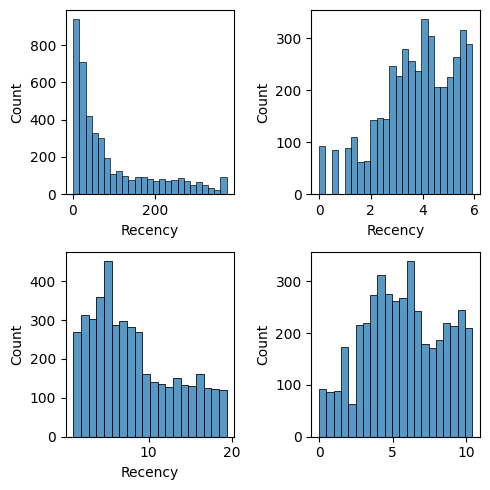

Normal: 1.25
Log: -0.55
Squared: 0.59
Boxcox: -0.07


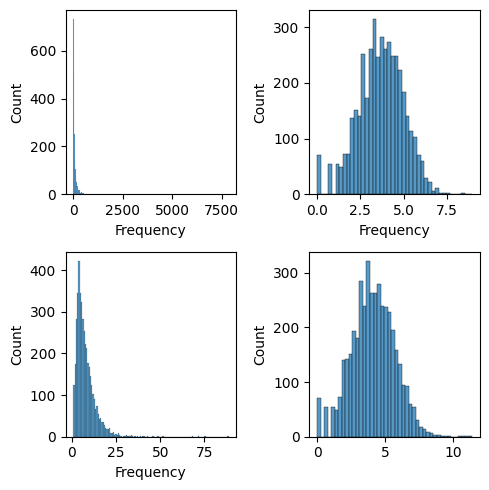

Normal: 18.11
Log: -0.22
Squared: 3.22
Boxcox: 0.0


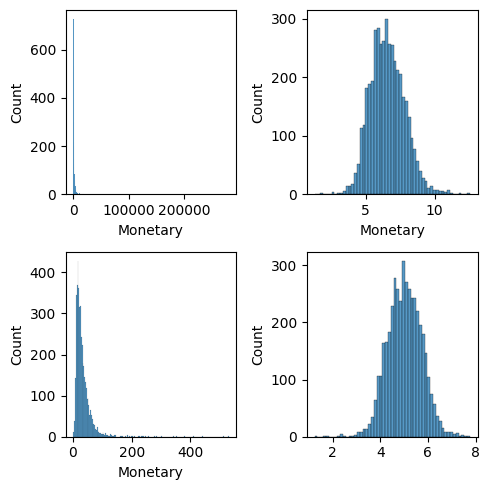

Normal: 19.32
Log: 0.38
Squared: 5.89
Boxcox: -0.02


In [162]:
analyze_skewness('Recency')
analyze_skewness('Frequency')
analyze_skewness('Monetary')

**Note**: After reviewing the results, I found that the Box-Cox transformation yielded the lowest skewness. Therefore, I will choose the Box-Cox transformation for my data.

In [163]:
# Apply boxcox transformation
df_customers_RFM = df_customer.copy()
df_customers_RFM['Recency'] = stats.boxcox(df_customers_RFM['Recency'])[0]
df_customers_RFM['Frequency'] = stats.boxcox(df_customers_RFM['Frequency'])[0]
df_customers_RFM['Monetary'] = pd.Series(np.sqrt(df_customers_RFM['Monetary'])).values

In [164]:
# check the dataset
df_customers_RFM

,Recency,Frequency,Monetary
CustomerID,,,
12346,10.039090,0.000000,277.819366
12347,0.737107,5.967408,65.650590
12348,6.460362,3.756089,42.393867
12349,3.855960,4.800962,41.923144
12350,9.900640,3.050162,18.286607
...,...,...,...
18280,9.605064,2.444553,13.438750
18281,8.494372,2.046672,8.989994
18282,2.509966,2.650775,13.343538


### **7. Feature Scaling**

In [165]:
# Scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_customers_RFM)
df_customers_scaled = scaler.transform(df_customers_RFM)

In [166]:
df_customers_scaled

array([[ 1.62487002, -2.57178095,  8.0419317 ],
       [-1.84163569,  1.16617768,  1.05392379],
       [ 0.29121018, -0.21898305,  0.28793849],
       ...,
       [-1.18095643, -0.91134674, -0.66886552],
       [-1.53137989,  2.37588685,  0.39913042],
       [-0.13039891,  0.40277588,  0.30340648]])

# **Modelling**

### **1. Determine the number of clusters using the Elbow method**

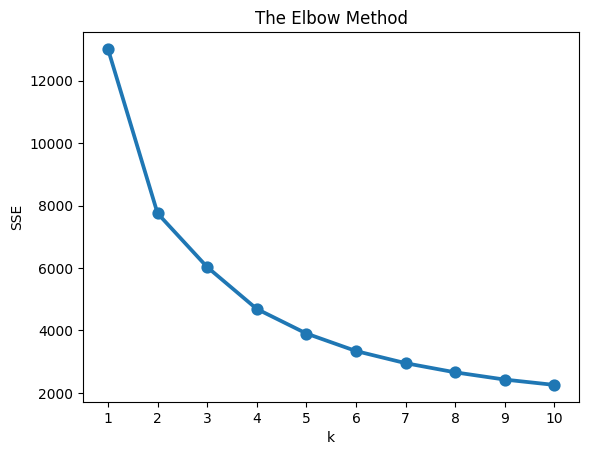

In [ ]:
# Choose the number of clusters by Elbow Method
from sklearn.cluster import KMeans

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_customers_scaled)
    sse[k] = kmeans.inertia_ 
    
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

**Note**: Based on the Elbow Method plot, I choose 3 clusters. This is the "elbow point," where the reduction in SSE (sum of squared errors) starts to slow down, indicating that increasing the number of clusters further does not significantly decrease SSE.

### **2. Customers Classification**

In [168]:
# Apply KMeans with cluster = 3
model = KMeans(n_clusters=3, random_state=42)
model.fit(df_customers_scaled)

KMeans(n_clusters=3, random_state=42)

In [ ]:
# Add the cluster to the dataset
df_customers_RFM['Cluster'] = model.labels_
df_customers_RFM.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346,10.039090,0.000000,277.819366,2
12347,0.737107,5.967408,65.650590,2
12348,6.460362,3.756089,42.393867,0
12349,3.855960,4.800962,41.923144,0
12350,9.900640,3.050162,18.286607,1


In [ ]:
# Check the dataset
df_customers_RFM

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346,10.039090,0.000000,277.819366,2
12347,0.737107,5.967408,65.650590,2
12348,6.460362,3.756089,42.393867,0
12349,3.855960,4.800962,41.923144,0
12350,9.900640,3.050162,18.286607,1
...,...,...,...,...
18280,9.605064,2.444553,13.438750,1
18281,8.494372,2.046672,8.989994,1
18282,2.509966,2.650775,13.343538,0


In [ ]:
# Check the mean of each cluster
df_customers_RFM.groupby('Cluster').agg(
    {
        'Recency':'mean',
        'Frequency':'mean',
        'Monetary':'mean'
    }
).round(2)

,Recency,Frequency,Monetary
Cluster,,,
0,4.34,4.63,33.25
1,8.02,2.87,19.17
2,2.60,6.54,89.69


In [176]:
df_customers_RFM["Cluster"] = df_customers_RFM["Cluster"].apply(lambda x: "New Customer" if x == 0 else ("Low-Value Customer" if x == 1 else "High-Value Customer"))

# **Customer Insights**

Here's the detailed classification for each customer cluster based on the table:
### **1. New Customer (Cluster 0)**
- **Recency**: Customers visit with moderate recency (4.34).
- **Frequency**: Moderate transaction frequency (4.63).
- **Monetary**: Average spending value (33.25).
- **Policies for this customer**: This group is new customers. To attract and retain new customers, businesses should offer appealing policies. A first-time discount encourages customers to try the product, while excellent customer service builds trust. Easy return policies help alleviate concerns about product quality. Loyalty programs or reward points can motivate repeat purchases. These strategies create lasting relationships between customers and the business.

### **2. Low-Value Customers (Cluster 1)**
- **Recency**: It’s been a while since these customers last visited (8.02).
- **Frequency**: Low transaction frequency (2.87).
- **Monetary**: Lowest spending value among the three clusters (19.17).
- **Policies for this customer**: These customers make only a few purchases and rarely return. The business needs to investigate why these customers are buying infrequently. It could apply strategies such as promotions or better customer care to engage them. Alternatively, the business might choose to pay less attention to these customers and focus more on those who bring higher value.

### **3. High-Value Customers (Cluster 2)**
- **Recency**: These customers have visited recently (2.60).
- **Frequency**: High transaction frequency (6.54).
- **Monetary**: Highest spending value among the clusters (89.69).
- **Policies for this customer**: For high-value customers, businesses can offer personalized rewards, VIP customer service, and exclusive promotions. Early access to new products and events enhances their experience. Providing flexible payment terms and expedited shipping shows appreciation for their loyalty. Special discounts and personalized marketing can increase engagement and satisfaction. Recognizing milestones with thoughtful gestures will strengthen the relationship and foster long-term loyalty.
